In [1]:
import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, Conv2D, MaxPool2D, Conv2D,BatchNormalization
from keras.callbacks import ReduceLROnPlateau

Reading Train and Test CSV

In [3]:
X_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

y_train = X_train.pop('label')

In [4]:
print(X_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

In [6]:
img_rows,img_cols=28,28
input_shape = (img_rows,img_cols,1)
batch_size=128
num_classes =10
epochs = 20

Reshaping to Single Channel

In [7]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

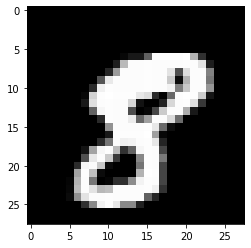

In [8]:
index  = 10
k = X_train[index,:]
k = k.reshape((28, 28))
plt.imshow(k, cmap='gray')

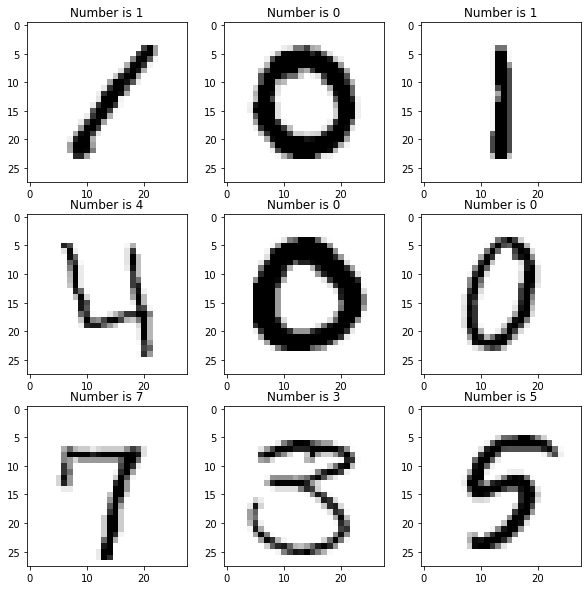

In [9]:
fig, axis=plt.subplots(3, 3, figsize=(10, 10))
y_train1 = y_train.reshape(1, len(y_train))
for index, ax in enumerate(axis.flat):
        ax.imshow(X_train[index],cmap=plt.cm.binary)
        ax.set(title = f"Number is {y_train1[0,index]}")

Comverting Class Labels to One Hot Encoded Vectors

In [10]:
# convert class labels (from digits) to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
print(y_train.shape)

(42000, 10)


In [11]:
X_train.dtype

dtype('int64')

In [12]:
# convert int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalise
X_train /= 255
X_test /= 255

Training Model

In [13]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same',input_shape=(img_rows, img_cols, 1),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(32, kernel_size=(3, 3), padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        1

2022-05-20 09:29:45.474174: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer = 'adam',
             metrics = ['accuracy'])


In [15]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,callbacks=[lr_reduction])

2022-05-20 09:29:46.109435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
329/329 [==============================] - 103s 309ms/step - loss: 0.1513 - accuracy: 0.9533
Epoch 2/20
329/329 [==============================] - 102s 310ms/step - loss: 0.0532 - accuracy: 0.9838
Epoch 3/20
329/329 [==============================] - 102s 310ms/step - loss: 0.0368 - accuracy: 0.9880
Epoch 4/20
329/329 [==============================] - 102s 310ms/step - loss: 0.0329 - accuracy: 0.9891
Epoch 5/20
329/329 [==============================] - 103s 312ms/step - loss: 0.0271 - accuracy: 0.9910
Epoch 6/20
329/329 [==============================] - 103s 312ms/step - loss: 0.0236 - accuracy: 0.9922
Epoch 7/20
329/329 [==============================] - 103s 312ms/step - loss: 0.0202 - accuracy: 0.9931
Epoch 8/20
329/329 [==============================] - 103s 314ms/step - loss: 0.0181 - accuracy: 0.9938
Epoch 9/20
329/329 [==============================] - 104s 316ms/step - loss: 0.0168 - accuracy: 0.9944
Epoch 10/20
329/329 [==============================] - 104s 314m

Model Prediction

In [16]:
X_test_pred = model.predict(X_test)

In [17]:
X_test_pred.shape

(28000, 10)

In [18]:
output = pd.DataFrame({"Label": X_test_pred.argmax(axis=1)}, index=range(1, 28001))
output.index.name = "ImageId"
output.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [19]:
output.to_csv("submission.csv")